In [3]:
#LIBRERIAS
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras import layers, models, regularizers
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
import seaborn as sns
import collections

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow import keras

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#direccion = "../content/drive/MyDrive/Img_Preprocessing_Binary/"
#Img_Preprocessing_Binary_6200
direccion = "../content/drive/MyDrive/Img_Preprocessing_Binary_3200/"

In [6]:
train_data = tf.keras.utils.image_dataset_from_directory(
    direccion,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32)

valid_data = tf.keras.utils.image_dataset_from_directory(
    direccion,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32)

Found 6400 files belonging to 2 classes.
Using 5120 files for training.
Found 6400 files belonging to 2 classes.
Using 1280 files for validation.


In [7]:
class_names = train_data.class_names
print(class_names)
class_counts = {}

['00_NO DR', '01_DR']


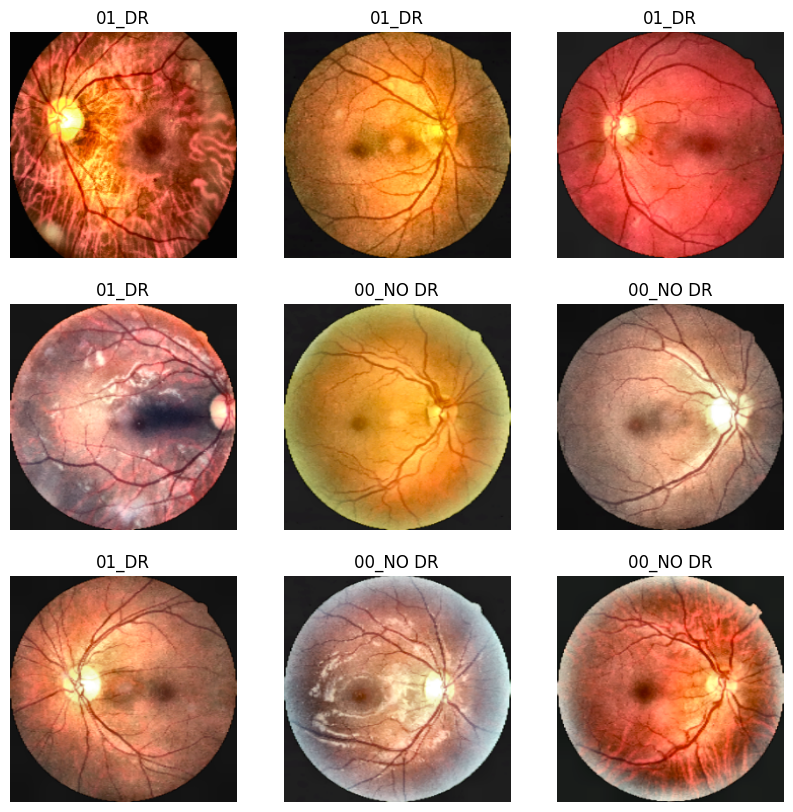

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    #tf.keras.layers.RandomContrast(0.1),
    #tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.Rescaling(1./255),
])

normalization_layer = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])

In [10]:
datos_normalizados = train_data.map(lambda x, y: (normalization_layer(x), y))
images_batch, label_batch = next(iter(datos_normalizados))

first_image = images_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [11]:
train_data = train_data.map(lambda x, y: (data_augmentation(x), y))
valid_data = valid_data.map(lambda x, y: (normalization_layer(x), y))

In [12]:
for images, labels in train_data.take(1):
    print("Train - min:", tf.reduce_min(images).numpy(), "max:", tf.reduce_max(images).numpy())

for images, labels in valid_data.take(1):
    print("Validation - min:", tf.reduce_min(images).numpy(), "max:", tf.reduce_max(images).numpy())

Train - min: 0.0 max: 1.0
Validation - min: 0.0 max: 1.0


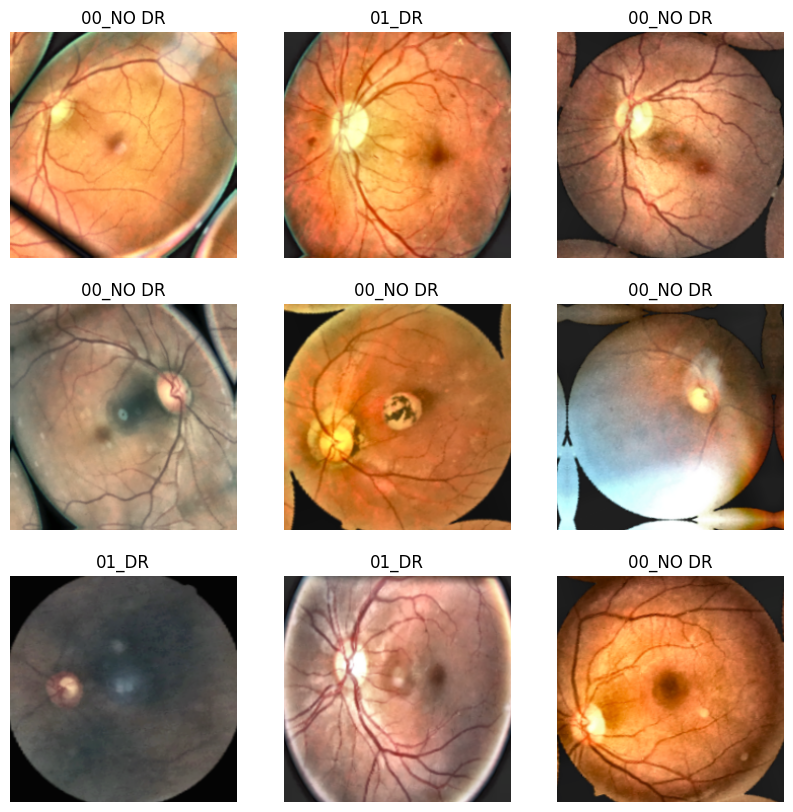

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i].numpy()*255).astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=(256, 256, 3)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(),

#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(),

#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(),

#     tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(),

#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

In [16]:
model = tf.keras.Sequential([
    # Bloque 1
    layers.Conv2D(16, (3, 3), activation='relu', padding='same',
                  kernel_initializer='he_normal',
                  input_shape=(256, 256, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Bloque 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                  kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                  kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Bloque 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                  kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                  kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Bloque 4
    layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                  kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),

     # Bloque 4
    layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                  kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# model = tf.keras.Sequential([
#     # Bloque 1
#     layers.Conv2D(16, (3, 3), activation='relu', padding='same',
#                   kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001),
#                   input_shape=(256, 256, 3)),
#     layers.BatchNormalization(),
#     layers.Conv2D(32, (3, 3), activation='relu', padding='same',
#                   kernel_initializer='he_normal'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(pool_size=(2, 2)),

#     # Bloque 2
#     layers.Conv2D(64, (3, 3), activation='relu', padding='same',
#                   kernel_initializer='he_normal'),
#     layers.BatchNormalization(),
#     layers.Conv2D(64, (3, 3), activation='relu', padding='same',
#                   kernel_initializer='he_normal'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(pool_size=(2, 2)),

#     # Bloque 3
#     layers.Conv2D(128, (3, 3), activation='relu', padding='same',
#                   kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)),
#     layers.BatchNormalization(),
#     layers.Conv2D(128, (3, 3), activation='relu', padding='same',
#                   kernel_initializer='he_normal'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(pool_size=(2, 2)),

#     # Bloque 4
#     layers.Conv2D(256, (3, 3), activation='relu', padding='same',
#                   kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)),
#     layers.BatchNormalization(),
#     layers.GlobalAveragePooling2D(),

#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(1, activation='sigmoid')
# ])

In [18]:
# model = tf.keras.Sequential([
#     # Bloque 1
#     layers.Conv2D(16, (3, 3), activation='relu', padding='same',
#                   kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001),
#                   input_shape=(256, 256, 3)),
#     layers.BatchNormalization(),
#     layers.Conv2D(32, (3, 3), activation='relu', padding='same',
#                   kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(pool_size=(2, 2)),

#     # Bloque 2
#     layers.Conv2D(64, (3, 3), activation='relu', padding='same',
#                   kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)),
#     layers.BatchNormalization(),
#     layers.Conv2D(64, (3, 3), activation='relu', padding='same',
#                   kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(pool_size=(2, 2)),

#     # Bloque 3
#     layers.Conv2D(128, (3, 3), activation='relu', padding='same',
#                   kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)),
#     layers.BatchNormalization(),
#     layers.Conv2D(128, (3, 3), activation='relu', padding='same',
#                   kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(pool_size=(2, 2)),

#     # Bloque 4
#     layers.Conv2D(256, (3, 3), activation='relu', padding='same',
#                   kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)),
#     layers.BatchNormalization(),
#     layers.GlobalAveragePooling2D(),

#     # Clasificación
#     layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     layers.Dropout(0.4),
#     layers.Dense(1, activation='sigmoid')  # Salida binaria
# ])

In [19]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)),
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.MaxPooling2D(),

#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(),

#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(),

#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])


In [20]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,237,025 (4.72 MB)

 Trainable params: 1,235,137 (4.71 MB)

 Non-trainable params: 1,888 (7.38 KB)

In [21]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [24]:
history = model.fit(train_data,
                    validation_data = valid_data,
                    callbacks=[early_stopping],
                    epochs=100,
                    verbose=1)

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 680s 4s/step - accuracy: 0.5372 - loss: 1.8359 - val_accuracy: 0.5242 - val_loss: 1.7757
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - accuracy: 0.5552 - loss: 1.7524 - val_accuracy: 0.5258 - val_loss: 1.7224
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 41s 136ms/step - accuracy: 0.5643 - loss: 1.6700 - val_accuracy: 0.5695 - val_loss: 1.6216
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - accuracy: 0.5786 - loss: 1.5925 - val_accuracy: 0.5898 - val_loss: 1.5401
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - accuracy: 0.5849 - loss: 1.5180 - val_accuracy: 0.5906 - val_loss: 1.4731
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.5973 - loss: 1.4489 - val_accuracy: 0.5953 - val_loss: 1.4146
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - accuracy: 0.5996 - loss: 1.3853 - val_accuracy: 0.5805 - val_loss: 1.3662
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 42s 145ms/step - accuracy: 0.6076 - l

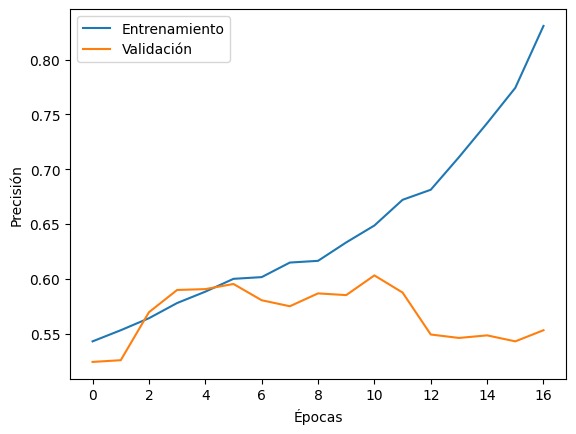

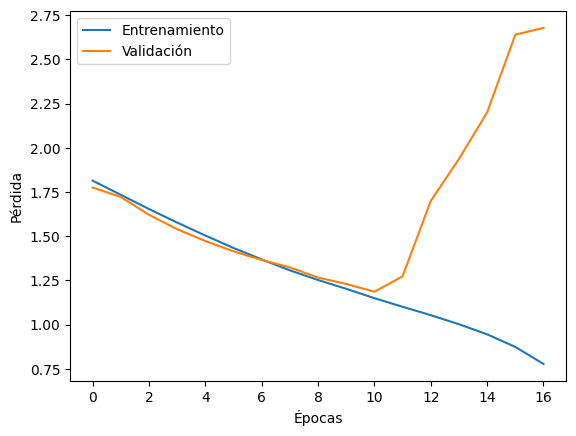

In [25]:
# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [26]:
loss, accuracy = model.evaluate(valid_data)
print('Loss:', loss)
print('Accuracy:', accuracy)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6059 - loss: 1.1806
Loss: 1.1862857341766357
Accuracy: 0.6031249761581421


In [27]:
y_pred_probs = model.predict(valid_data)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


In [28]:
y_true = []
for images, labels in valid_data:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

In [29]:
print(y_true)

[1 0 0 ... 0 0 1]


In [30]:
print(y_pred)

[0 0 0 ... 0 1 1]


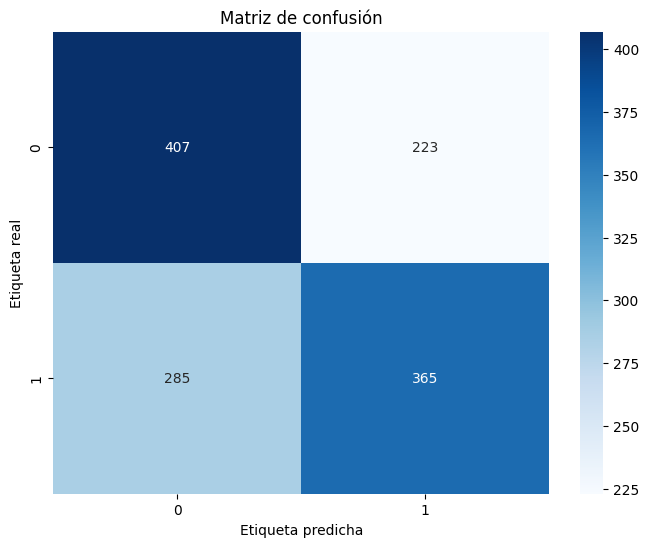

In [31]:
matriz_conf = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_conf, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de confusión")
plt.xlabel("Etiqueta predicha")
plt.ylabel("Etiqueta real")
plt.show()

In [35]:
model.save('model.keras')

In [33]:
from sklearn.metrics import classification_report

In [34]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.65      0.62       630
           1       0.62      0.56      0.59       650

    accuracy                           0.60      1280
   macro avg       0.60      0.60      0.60      1280
weighted avg       0.60      0.60      0.60      1280

